In [ ]:
!pip install stable-baselines3[extra] gymnasium[mujoco] -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import time
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
import numpy as np

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
chk_path = "/content/drive/MyDrive/RL_Checkpoints/walker-2d"
env_name = "Walker2d-v5"
algorithm = "ppo"

In [ ]:
os.makedirs(os.path.join(chk_path, env_name), exist_ok=True)

In [ ]:
vec_env = make_vec_env(lambda: Monitor(gym.make(env_name)), n_envs=4)

In [ ]:
env = Monitor(gym.make(env_name))


In [ ]:
checkpoint_callback = CheckpointCallback(save_freq=50000, save_path=chk_path, name_prefix=env_name)
eval_callback = EvalCallback(
    env,
    best_model_save_path=chk_path,
    log_path=os.path.join(chk_path, "eval_logs"),
    eval_freq=10000,
    deterministic=True,
    render=False,
)

In [ ]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=chk_path)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [ ]:
# try:
#     print("training started...")
#     total_training_time = 3 * 60 * 60  # 3 hours
#     start_time = time.time()

#     while time.time() - start_time < total_training_time:
#         model.learn(
#             total_timesteps=200000,
#             callback=[checkpoint_callback, eval_callback],progress_bar=True,)
#         model.save(os.path.join(chk_path, f"{env_name}_latest"))

# except KeyboardInterrupt:
#     print("Keyboard. Saving latest model: ")
#     model.save(os.path.join(chk_path, f"{env_name}_interrupted"))

# model.save(os.path.join(chk_path, f"{env_name}_final"))
# vec_env.close()
# env.close()

  78% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 156,714/200,000  [ 0:08:21 < 0:02:20 , 311 it/s ]

In [ ]:
rewards_path = "/content/drive/MyDrive/RL_Checkpoints/walker-2d/rewards.npy"
rewards = np.load(rewards_path)
print(type(rewards))
print(rewards.shape)
print(rewards[:10])


<class 'numpy.ndarray'>
(1,)
[278.23536]


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy


model = PPO.load(os.path.join(chk_path, f"{env_name}_final"))
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Trained Agent: Mean Reward = {mean_reward}, Std Reward = {std_reward}")

random_agent = lambda _: env.action_space.sample()
random_rewards = []
for _ in range(10):
    obs,_ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = random_agent(obs)
        obs, reward, terminate, truncate ,_= env.step(action)
        done = terminate or truncate
        total_reward += reward
    random_rewards.append(total_reward)

print(f"Random Agent: Mean Reward = {np.mean(random_rewards)}, Std Reward = {np.std(random_rewards)}")


Trained Agent: Mean Reward = 3430.7407297000004, Std Reward = 978.7313230987836
Random Agent: Mean Reward = 3.8348914801469305, Std Reward = 7.398245157898135


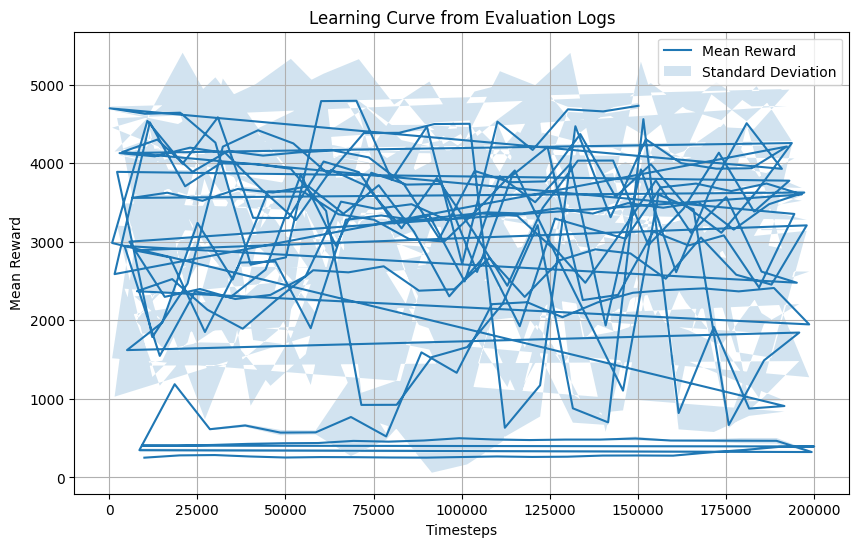

In [ ]:
eval_logs_path = "/content/drive/MyDrive/RL_Checkpoints/walker-2d/eval_logs/evaluations.npz"
eval_data = np.load(eval_logs_path)

timesteps = eval_data["timesteps"]
mean_rewards = eval_data["results"].mean(axis=1)
std_rewards = eval_data["results"].std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(timesteps, mean_rewards, label="Mean Reward")
plt.fill_between(
    timesteps,
    mean_rewards - std_rewards,
    mean_rewards + std_rewards,
    alpha=0.2,
    label="Standard Deviation",
)
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("Learning Curve from Evaluation Logs")
plt.legend()
plt.grid()
plt.show()
